In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
from bisect import bisect
import operator
import os
from os import listdir
from os.path import isfile, join
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import MinMaxScaler
plt.rcParams.update({'figure.max_open_warning': 0})
import operator

In [9]:
def read_combined_data(filename,airbag_data):
    data = pd.read_excel (combined_path+filename)
    data = data[(data['eventLabel']>100) & (data['eventLabel'] < 200) &
                (data['impactTime_ms'].notnull()) & ((data['eventStart_ms']) < (airbag_data.iloc[-1][0]))
                & (data['impactTime_ms'] != 0)]
    data = data[['eventLabel','eventStart_ms','impactTime_ms', 'eventEnd_ms','eventDuration_ms']]
    data.columns = ['eventLabel','Start milisec','Impact milisec', 'End Milisec','eventDuration_ms']
    return data

In [10]:
# Adding the fall value by choosing the maximum magitude in the fall range from combined data
time_div = 10**3
def add_new_fall_value(airbag_data,manual_data):
    airbag_data['accel_base_mag'] =  np.sqrt(airbag_data['accel_base_X']**2 + airbag_data['accel_base_Y']**2 + 
                                             airbag_data['accel_base_Z']**2)
    print("shape of falls combined ",manual_data.shape)
    for index, row in manual_data.iterrows():
        airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) &
                        (airbag_data['time_counter'] < row['End Milisec']),'fall_check'] = 88
        temp = airbag_data.loc[(airbag_data['accel_base_mag'] == \
                                                  (airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) & \
                                                                   (airbag_data['time_counter'] < row['End Milisec']),
                                                                   'accel_base_mag'].max())) & \
                                                 (airbag_data['time_counter'] >= row['Start milisec']) & \
                                                 (airbag_data['time_counter'] < row['End Milisec'])]
        
        airbag_data.loc[airbag_data.time_counter == temp.iloc[0,0], 'cal_impact_milisec'] = 80
        if(any(airbag_data['time_counter'] == row['Impact milisec'])):
            airbag_data.loc[(airbag_data['time_counter'] == row['Impact milisec']),'impact_value'] =  84
        else:
            airbag_data.loc[bisect(airbag_data['time_counter'].values, row['Impact milisec']),'impact_value'] =  84

In [11]:
def big_size_plot_of_acceleration_vs_time(data, name, x=15, y=10, left = -1, right = -1):
    fig, axs = plt.subplots(figsize=(x,y))
    fig.suptitle('Bace acceleration for AIRBAG-'+name)
    G = 2048
    data['accel_base_mag'] =  np.sqrt(data['accel_base_X']**2 + data['accel_base_Y']**2 + 
                                             data['accel_base_Z']**2)
    axs.plot( data.time_counter/time_div,data.accel_base_X/G, marker='', color='red', linewidth=1, label='X')
    axs.plot( data.time_counter/time_div,data.accel_base_Y/G, marker='', color='blue', linewidth=1, label='Y')
    axs.plot( data.time_counter/time_div,data.accel_base_Z/G, marker='', color='green', linewidth=1, label='Z')
    axs.plot( data.time_counter/time_div,data.accel_base_mag/G, marker='', color='black', linewidth=1, label='Magnitude')
    axs.axhline(y=5, linewidth=2,linestyle ='--', color='y',label = "5G")
#     axs.scatter(data.time_counter/time_div,data.cal_impact_milisec/4,s=30,c = 'violet')
    
    if (left>-1 and right>-1):
        axs.set_xlim(left,right)
    elif (left > -1):
        axs.set_xlim(left)
    elif (right > -1):
        axs.set_xlim(right)
    else:
        axs.set_xlim()
    
    axs.legend()
    axs.set_title('Data')

In [12]:
def acceleration_vs_time(data,label):
    fig, axs = plt.subplots(2, 2,figsize=(15,10))
    fig.suptitle('Bace acceleration for AIRBAG-'+label)
    G = 2048
    axs[0, 0].plot(data.time_counter/time_div,data.accel_base_X/G, marker='', color='red', linewidth=1)
    axs[0, 0].scatter(data.time_counter/time_div,data.fall_detection/4,s=5,c = 'brown')
    axs[0, 0].set_title('acceleration X')
    
    axs[0, 1].plot(data.time_counter/time_div,data.accel_base_Y/G, marker='', color='blue', linewidth=1)
    axs[0, 1].scatter(data.time_counter/time_div,data.fall_detection/4,s=5,c = 'brown')
    axs[0, 1].set_title('acceleration Y')
    
    axs[1, 0].plot(data.time_counter/time_div,data.accel_base_Z/G, marker='', color='green', linewidth=1)
    axs[1, 0].scatter(data.time_counter/time_div,data.fall_detection/4,s=5,c = 'brown')
    axs[1, 0].set_title('acceleration Z')
    
    axs[1, 1].plot( data.time_counter/time_div,data.accel_base_X/G, marker='', color='red', linewidth=1)
    axs[1, 1].plot( data.time_counter/time_div,data.accel_base_Y/G, marker='', color='blue', linewidth=1)
    axs[1, 1].plot( data.time_counter/time_div,data.accel_base_Z/G, marker='', color='green', linewidth=1)
    axs[1, 1].scatter(data.time_counter/time_div,data.fall_detection/4,s=5,c = 'brown')
    
    axs[1, 1].set_title('acceleration all axis')

In [13]:
def plot_falls_zoomed(subject, left, right, name, fn, width=10, height=8):
    fig, axs = plt.subplots(figsize=(width, height))
    falls = subject.loc[subject["cal_impact_milisec"] == 80]
    fall_times = falls['time_counter'].values.tolist()
    
    fig.suptitle("Subject " + name + " - Fall Number " + str(fn+1) + " - Occurs at " + str(fall_times[fn] * (10 ** (-3))) + " s")
    fc = 1
    G = 2048
    # Get Indexes for time
    start_time = fall_times[fn] - left
    end_time = fall_times[fn] + right
    start_time = subject.loc[subject["time_counter"] == start_time].index[0]
    end_time = subject.loc[subject["time_counter"] == end_time].index[0]

    # Setup X and Y for plotting
    time = subject.loc[start_time:end_time, 'time_counter'] / time_div
    accel = subject.loc[start_time:end_time, 'accel_base_mag'] / G
    x = subject.loc[start_time:end_time, 'accel_base_X'] / G
    y = subject.loc[start_time:end_time, 'accel_base_Y'] / G
    z = subject.loc[start_time:end_time, 'accel_base_Z'] / G
#     fall = subject.loc[start_time:end_time, 'cal_impact_milisec'] *(10**(-3))
# 
    # Plot Graphs
    plt.xlabel("Time in (s)")
    plt.ylabel("XYZ, Magnitude")
    axs.plot(time, accel, marker='', color='black', linewidth=1, alpha = 0.8, label="Accel")
    axs.plot(time, x, marker='', color='blue', linewidth=1, alpha = 0.8, label="X")
    axs.plot(time, y, marker='', color='green', linewidth=1, alpha = 0.8, label="Y")
    axs.plot(time, z, marker='', color='red', linewidth=1, alpha = 0.8, label="Z")
    axs.axhline(y=5, linewidth=2,linestyle ='--', color='y',label = "5G")
    
    # Plot Max Fall Time
    plt.axvline(x = fall_times[fn] / time_div, color="m", linewidth=1, label="Impact")
    
    
    # Plot One Second Rem Range
    plt.axvline(x = fall_times[fn] / time_div + 1, color="m", linewidth=3, label="Fall Radius")
    plt.axvline(x = fall_times[fn] / time_div - 1, color="m", linewidth=3)

    ul = max(max(accel), max(x), max(y), max(z)) + 5
    dl = min(min(accel), min(x), min(y), min(z)) - 5
     
    plt.ylim(dl, ul)
    plt.legend()
    return fig

In [28]:
def extract_rnn_feature(data,window_time=1000,move_window = 0):
    
    max_ms = data['time_counter'].max()
    feature = pd.DataFrame(columns={'time_counter','accel_base_X','accel_base_Y','accel_base_Z','accel_base_mag','fall_value'})
    impact_list = data.loc[(data['cal_impact_milisec'] == 80),'time_counter'].values
    feature[['time_counter','accel_base_mag','accel_base_X','accel_base_Y','accel_base_Z']] = data[['time_counter','accel_base_mag','accel_base_X','accel_base_Y','accel_base_Z']]  
    feature['fall_value'] = np.zeros((feature.shape[0],1))
#     print(impact_list)
    for i in impact_list:
        
        temp = data.loc[data['time_counter'] <= i-move_window].tail(1).values[0][0]
        feature.loc[feature['time_counter'] == temp,'fall_value' ] = 1
    return feature

## Reading all files and printing their shape

In [30]:
subjects = ['S4','S5','S6','S7','S12','S13','S14','S16','S19']

for subject in subjects[]:
    data_path = "../../../Airbag_Data/Strokes_data/"+subject+"_Raw Data/Airbag/"
    combined_path = "../../../Airbag_Data/Strokes_data/combined excel files/"
    files = [f for f in listdir(data_path) if isfile(join(data_path, f)) and '.CSV' in f]
    files.sort()
    print(subject,files, len(files))

    concatenate_csv = pd.concat([pd.read_csv(data_path+f,names = ['time_counter','accel_base_X','accel_base_Y','accel_base_Z','gyro_base_X',
                                                      'gyro_base_Y','gyro_base_Z','accel_right_X','accel_right_Y','accel_right_Z',
                                                      'gyro_right_X','gyro_right_Y','gyro_right_Z','accel_left_X','accel_left_Y',
                                                      'accel_left_Z','gyro_left_X','gyro_left_Y','gyro_left_Z','fall_detection',
                                                      'fall_check','impact_value']) for f in files ],ignore_index=True)
    combined = read_combined_data(subject+"_CombinedData.xls",concatenate_csv)
    add_new_fall_value(concatenate_csv,combined)
    
    move_window = [10,100,200,300,400,2000]
    for index in move_window:
        print("labelling moved window of:{} ms".format(index))
        feature = extract_rnn_feature(concatenate_csv,move_window=index)
        #saving labels of each subject on a particular moving window
        feature.to_csv("../../../Label_data/"+subject+"_"+str(index)+".csv", sep=',',index=False)
        

S5 ['S5-Airbag.CSV'] 1
shape of falls combined  (29, 5)
labelling moved window of:10 ms
labelling moved window of:100 ms
labelling moved window of:200 ms
labelling moved window of:300 ms
labelling moved window of:400 ms
labelling moved window of:2000 ms
S6 ['S6-Airbag.CSV'] 1
shape of falls combined  (25, 5)
labelling moved window of:10 ms
labelling moved window of:100 ms
labelling moved window of:200 ms
labelling moved window of:300 ms
labelling moved window of:400 ms
labelling moved window of:2000 ms
S7 ['S7-Airbag.CSV'] 1
shape of falls combined  (32, 5)
labelling moved window of:10 ms
labelling moved window of:100 ms
labelling moved window of:200 ms
labelling moved window of:300 ms
labelling moved window of:400 ms
labelling moved window of:2000 ms
S12 ['S12-Airbag.CSV'] 1
shape of falls combined  (15, 5)
labelling moved window of:10 ms
labelling moved window of:100 ms
labelling moved window of:200 ms
labelling moved window of:300 ms
labelling moved window of:400 ms
labelling moved 

### Concatinating all the files in the sorted order

In [ ]:

 
move_window = [10,100,200,300,400,2000]
 
for index in move_window:
    print("extracting features on moved window frame by:{} ms".format(index))
    data_count = 1
    for temp_data in data:
        feature = extract_rnn_feature(temp_data,move_window=index)
        #saving labels of each subject on a particular moving window
        feature.to_csv("Programs/RNN_features/"+str(index)+"_"+str(data_count)+ ".csv", sep=',',index=False)
        data_count += 1

In [20]:
def plot_fall_mag(concatenate_csv,subject):
    fig = plt.figure(figsize = (15,8))
    ax = fig.add_axes([0,0,1,1])
    G = 2048
    falls = [ i+1 for i in range(concatenate_csv.loc[concatenate_csv['cal_impact_milisec'] == 80].shape[0]) ]
    acc_mag = concatenate_csv.loc[concatenate_csv['cal_impact_milisec'] == 80,'accel_base_mag'].tolist()
    acc_mag = [element/G for element in acc_mag]
    ax.bar(falls,acc_mag)
    plt.title(subject + '_Falls magnitude',fontsize = 22)
    plt.xlabel('Falls',fontsize = 18)
    plt.ylabel('Acc mag in g',fontsize = 18)
    plt.savefig(subject + '.png',dpi=300, bbox_inches='tight')
    plt.show()


## Generate All falls magnitudes

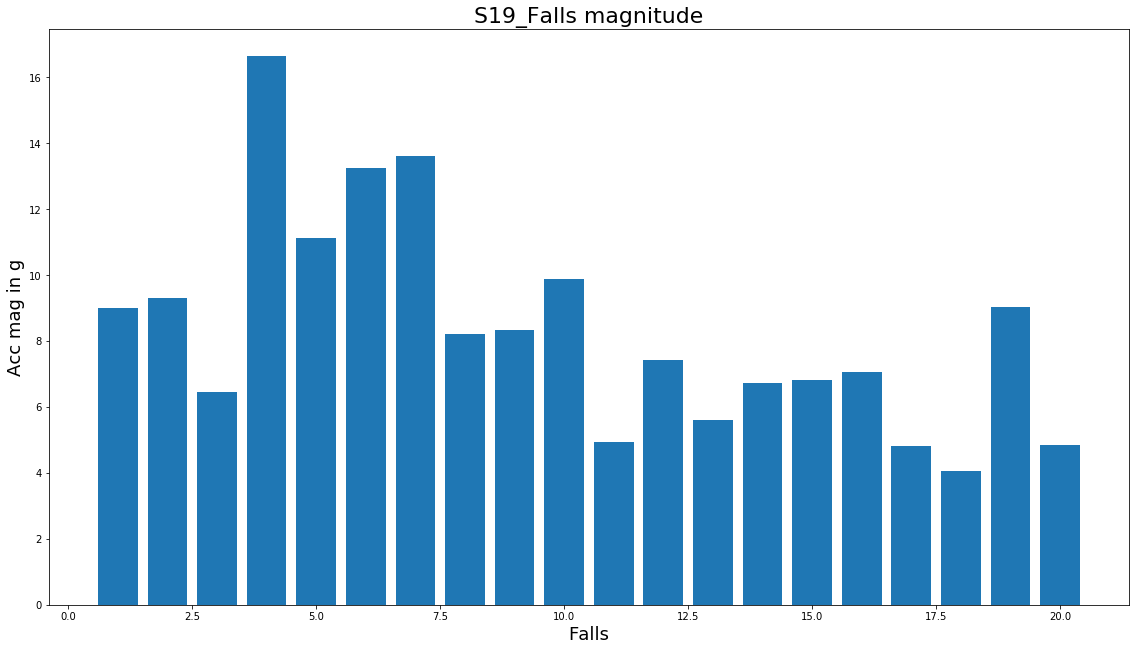

In [21]:
plot_fall_mag(concatenate_csv,subject)

## Plotting the XYZ graphs of the accelerometer for S12

In [30]:
def generate_5g_csv(concatenate_csv,subject):
    
    temp = concatenate_csv.loc[concatenate_csv['accel_base_mag'] > 5.0 * 2048]
    temp.to_csv(subject+"_5G.csv",index = False)
    times = temp['time_counter'].to_numpy()
    times = np.concatenate(([0],times)) # add 0 to the beginning to append the first value
    fall_start_times = [] # Start times of all fall windows
    for x in range(0, len(times)-1):
        if (times[x+1] - times[x] > 8000): # if they are in a different window (just a guess that we can't have two falls w/in one second)
            fall_start_times.append(times[x+1] * (10**(-3)))
    return fall_start_times


In [31]:
def generate_5g_combine(concatenate_csv,subject):
        temp = concatenate_csv.loc[(concatenate_csv['cal_impact_milisec'] == 80) & 
                            (concatenate_csv['accel_base_mag'] > 5*2048) ]
        temp = temp.time_counter.to_list()
        temp = [ int(var)*(10**(-3)) for var in temp ]
        return temp
        
        

In [293]:
S4_5g_cal = generate_5g_csv(concatenate_csv,subject)
S4_falls_combined = generate_5g_combine(concatenate_csv,subject)



## Plot stiched_5G vs actual falls

In [321]:
def plot_5g_accel(acc_mag_stiched,acc_mag_combined,subject):
    plt.figure(figsize=(10,10))
    plt.plot(acc_mag_stiched,linestyle='--', marker='o', color='b',linewidth = 2,  markersize=10,label = 'stitched')
    plt.plot(acc_mag_combined,linestyle='--', marker='v', color='r',label = 'actual')
    plt.ylabel('Time in seconds',fontsize = 18)
    plt.xlabel('Fall count', fontsize =18)
    plt.title(subject,fontsize = 24)
    plt.legend(loc="upper left",fontsize = 18)
    plt.show()

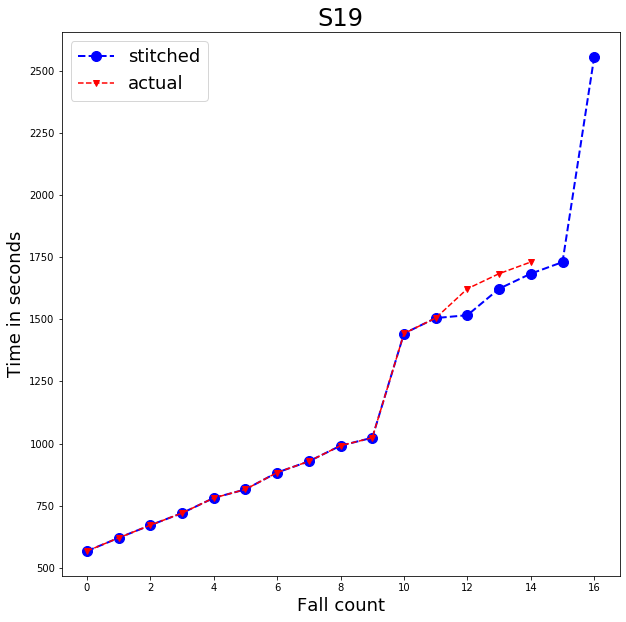

In [323]:
plot_5g_accel(S4_5g_cal,S4_falls_combined,subject)

In [322]:
print(S4_5g_cal)
print(S4_falls_combined)

[567.562, 620.75, 671.782, 720.508, 781.3580000000001, 815.91, 883.744, 928.8000000000001, 991.73, 1023.7180000000001, 1443.146, 1505.2640000000001, 1516.848, 1623.256, 1683.93, 1730.506, 2556.15]
[567.614, 620.804, 671.822, 720.5260000000001, 781.37, 815.924, 883.746, 928.8340000000001, 991.756, 1023.732, 1443.176, 1505.268, 1623.32, 1683.948, 1730.778]
